In [1]:
def match_cats(src, src_comp):

    from astropy.table import Table, vstack
    import numpy as np
    from copy import deepcopy

    t = Table()
    for col in src.getSchema().getNames():
        t[col] = deepcopy(src[col])

    t_comp = Table()
    for col in src_comp.getSchema().getNames():
        t_comp[col] = deepcopy(src_comp[col])
    
    import sys
    sys.path.insert(0,'/home/sr525/Python_Code')
    import match_lists

    ra = np.rad2deg(t["coord_ra"])
    dec = np.rad2deg(t["coord_dec"])

    ra_comp = np.rad2deg(t_comp["coord_ra"])
    dec_comp = np.rad2deg(t_comp["coord_dec"])
    print("Length of each catalogue:", len(t), len(t_comp))

    dist, inds = match_lists.match_lists(ra, dec, ra_comp, dec_comp, 1.0/3600.0)

    match = np.where( ( inds != len(ra_comp)) )[0]
    print("With match:", len(match))
    print("Difference in catalogue size:", len(ra)-len(ra_comp))

    t = t[match]
    t_comp = t_comp[inds[match]]
    
    return t, t_comp


In [2]:
def running_med(xs, ys, window, step_size=20):
    
    data = list(zip(xs, ys))
    data.sort(key = lambda t : t[0])
    [(xs), (ys)] = list(zip(*data))
    xs = np.array(xs)
    ys = np.array(ys)
    
    meds_out = []
    mads_out = []
    xs_out = []
    n = 0
    
    while n+window < len(ys):
        x = ys[n:n+window]
        xs_out.append(xs[n+window//2])
        med = np.median(x)
        meds_out.append(med)
        mads_out.append(mad(x, med))
        n += step_size
        
    return np.array(xs_out), np.array(meds_out), np.array(mads_out)

In [3]:
def mad(xs, med):
    
    return np.median(np.fabs(xs-med))

In [12]:
def flux_diff(t, t_comp, flux_col, g_type="div"):

    import matplotlib.pyplot as plt

    good = np.where((t[flux_col] == t[flux_col]) & (t_comp[flux_col]==t_comp[flux_col]))[0]

    xs = t[flux_col][good]
    if g_type == "div":
        ys = t[flux_col][good]/t_comp[flux_col][good]
    elif g_type == "sub":
        ys = t[flux_col][good] - t_comp[flux_col][good]

    med = np.median(ys)
    mad_ys = mad(ys, med)

    xs_out, meds_out, mads_out = running_med(xs, ys, 50)

    if g_type == "div":
        plt.axhline(1.0, ls = ":", color="k")
        plt.ylabel(flux_col + " compared, vanilla/4")
        
    elif g_type == "sub":
        plt.axhline(0.0, ls = ":", color="k")
        plt.ylabel(flux_col + " compared, vanilla - 4")
    plt.plot(xs, ys, "k.")
    plt.plot(xs_out, meds_out, "r.", label = "Running Median")
    plt.ylim(med-1.0*1.4826*mad_ys, med + 1.0*1.4826*mad_ys)
    plt.xscale("log")
    plt.axhline(med, label = "Median")
    plt.xlabel(flux_col)
    plt.legend()
    plt.show()

    print("Number of Sources:", len(t), "Median:", med, "Sigma MAD:", mad_ys*1.4826)
    
    return med, mad_ys*1.4826

In [13]:
def bright_flux_diff(t, t_comp, flux_col, g_type="div"):
    
    import numpy as np
    
    good = np.where((t[flux_col] == t[flux_col]))[0]
    thresh = np.percentile(t[flux_col][good], 70)
    ids = np.where((t[flux_col] > thresh))[0]
    
    print("All sources brighter than", thresh)
    med, sig_mad = flux_diff(t[ids], t_comp[ids], flux_col, g_type=g_type)
    
    return med, sig_mad

In [14]:
import lsst.daf.persistence as dafPersist
import lsst.afw.display as afwDisplay
import os

dir_comp = "/scratch/pprice/compression/ci_hsc/DATA/rerun/quantize4/"
butler_comp = dafPersist.Butler(inputs=dir_comp)

dir_van = "/scratch/pprice/compression/ci_hsc/DATA/rerun/vanilla/"
butler_van = dafPersist.Butler(inputs=dir_van)

dataDetails = {"filter": "HSC-R", "visit": 903334, "patch": "5,4", "tract": 0, "ccd": 100}

src_van = butler_van.get("forced_src", dataId=dataDetails)
src_comp = butler_comp.get("forced_src", dataId=dataDetails)

In [15]:
def visit_analysis(visit, filt, patch, tract, g_type="div"):
    
    ccds = []
    for filename in os.listdir(dir_comp + pointing + filt + "/tract" + str(tract)):
        if filename[11:17] == str(visit):
            ccds.append(int(filename[18:21]))
    i = 1
    for ccd in ccds:
        print("CCD:", ccd)
        dataDetails = {"filter": filt, "visit": visit, "patch": patch, "tract": tract, \
                       "ccd": ccd}
    
        src_van = butler_van.get("forced_src", dataId=dataDetails)
        src_comp = butler_comp.get("forced_src", dataId=dataDetails)

        t, t_comp = match_cats(src_van, src_comp)
        med, sig_mad = flux_diff(t, t_comp, flux_col, g_type=g_type)
    
        if i == 1:
            t_all = t
            t_all_comp = t_comp
        else:
            t_all = vstack([t_all, t])
            t_all_comp = vstack([t_all_comp, t_comp])
   
        i += 1

    print("All ccds in visit", visit)
    med_all, sig_mad_all = flux_diff(t_all, t_all_comp, flux_col, g_type=g_type)
    med_all_bright, sig_mad_all_bright = bright_flux_diff(t_all, t_all_comp, flux_col, \
                                                         g_type=g_type)
    
    return t_all, t_all_comp, med_all, sig_mad_all
  

In [16]:
from astropy.table import Table, vstack
import numpy as np

filt = "HSC-R"
visit = 903334
patch = "5,4"
tract = 0

if filt == "HSC-R":
    pointing = "00533/"
elif filt == "HSC-I":
    pointing = "00671/"

flux_col = "base_GaussianFlux_flux"
g_type = "sub"
visits = [903334, 903336, 903338, 903342, 903344, 903346]

i = 1
bad_cols = []
for visit in visits:
    print("Visit:", visit)
    ccds = []
    for filename in os.listdir(dir_comp + pointing + filt + "/tract" + str(tract)):
        if filename[11:17] == str(visit):
            ccds.append(int(filename[18:21])) 
    for ccd in ccds:
        src_van = butler_van.get("forced_src", dataId=dataDetails)
        src_comp = butler_comp.get("forced_src", dataId=dataDetails)

        t, t_comp = match_cats(src_van, src_comp)
 
        cols = t.columns
        cols = ["base_PsfFlux_flux"]
        print_out = True

        for col in cols:
            vals = t[col] - t_comp[col]
            good = np.where((vals == vals))[0]
            vals = vals[good]
            med_sub = np.median(vals)
            sig_mad_sub = 1.4826*mad(vals, med_sub)
    
            good = np.where((t[col] == t[col]))[0]
            med_in = np.median(t[col][good])
            sig_mad_in = 1.4826*mad(t[col][good], med_in)
    
            good = np.where((t_comp[col] == t_comp[col]))[0]
            med_comp = np.median(t_comp[col][good])
            sig_mad_comp = 1.4826*mad(t_comp[col][good], med_comp)
    
            vals_div = t[col]/t_comp[col]
            good_div = np.where((vals_div == vals_div))[0]
            vals_div = vals_div[good_div]
            med_div = np.median(vals_div)
            sig_mad_div = mad(vals_div, med_div)
    
            if np.fabs(1.0-med_in/med_comp) > 0.02 or \
               np.fabs(1.0-sig_mad_in/sig_mad_comp) > 0.02 or print_out:
    
                print(col)
                print("Subtracted:", med_sub, sig_mad_sub) 
                print("Divided:", med_div, sig_mad_div)
                print("Uncompressed:", med_in, sig_mad_in)
                print("Compressed:", med_comp, sig_mad_comp)
                print("Vanilla/Compressed:", med_in/med_comp, sig_mad_in/sig_mad_comp)
                print("|1-Van/comp|:", np.fabs(1.0-med_in/med_comp), np.fabs(1.0-sig_mad_in/sig_mad_comp))
                print("\n")
            
                bad_cols.append(col)
    
    

Visit: 903334
Length of each catalogue: 1105 1161
With match: 1069
Difference in catalogue size: -56
base_PsfFlux_flux
Subtracted: 0.0646156271359 10.2664823902
Divided: 1.0000140505 0.0110141265402
Uncompressed: 435.313542351 426.27057262
Compressed: 431.735917621 420.54953699
Vanilla/Compressed: 1.00828660434 1.01360371401
|1-Van/comp|: 0.00828660434412 0.0136037140135


Length of each catalogue: 1105 1161
With match: 1069
Difference in catalogue size: -56
base_PsfFlux_flux
Subtracted: 0.0646156271359 10.2664823902
Divided: 1.0000140505 0.0110141265402
Uncompressed: 435.313542351 426.27057262
Compressed: 431.735917621 420.54953699
Vanilla/Compressed: 1.00828660434 1.01360371401
|1-Van/comp|: 0.00828660434412 0.0136037140135


Length of each catalogue: 1105 1161
With match: 1069
Difference in catalogue size: -56
base_PsfFlux_flux
Subtracted: 0.0646156271359 10.2664823902
Divided: 1.0000140505 0.0110141265402
Uncompressed: 435.313542351 426.27057262
Compressed: 431.735917621 420.549536

In [17]:
print(len(bad_cols))
print(set(bad_cols))
print(len(set(bad_cols)))

17
{'base_PsfFlux_flux'}
1


base_PsfFlux_flux
903334
CCD: 100
Length of each catalogue: 1105 1161
With match: 1069
Difference in catalogue size: -56


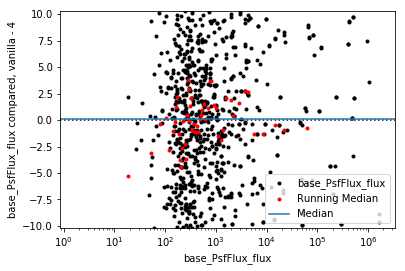

Number of Sources: 1069 Median: 0.0646156271359 Sigma MAD: 10.2664823902
CCD: 22
Length of each catalogue: 1154 1187
With match: 1117
Difference in catalogue size: -33


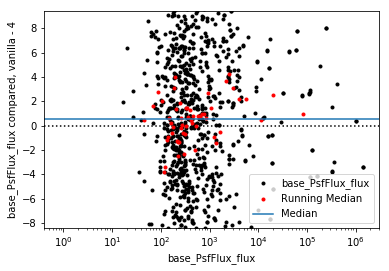

Number of Sources: 1117 Median: 0.507154171576 Sigma MAD: 8.93401075801
CCD: 23
Length of each catalogue: 1884 1970
With match: 1804
Difference in catalogue size: -86


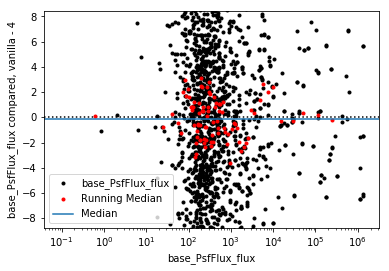

Number of Sources: 1804 Median: -0.163236628383 Sigma MAD: 8.6239743076
CCD: 16
Length of each catalogue: 1646 1743
With match: 1590
Difference in catalogue size: -97


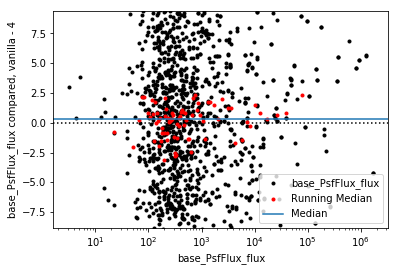

Number of Sources: 1590 Median: 0.289774296221 Sigma MAD: 9.12803573014
All ccds in visit 903334


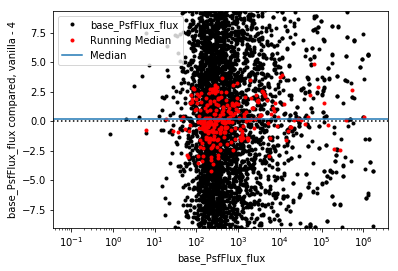

Number of Sources: 5580 Median: 0.164237023369 Sigma MAD: 9.21941895783
All sources brighter than 754.715418154


/software/lsstsw/stack3_20171023/python/miniconda3-4.3.21/lib/python3.6/site-packages/astropy/table/column.py:928: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, oper)(other)


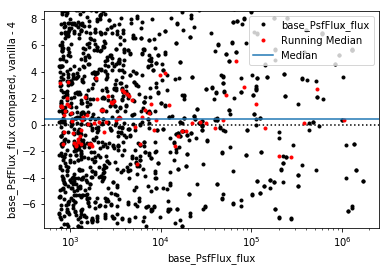

Number of Sources: 1672 Median: 0.409308859156 Sigma MAD: 8.19356904164
903336
CCD: 17
Length of each catalogue: 2318 2430
With match: 2237
Difference in catalogue size: -112


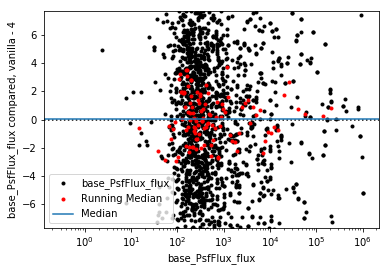

Number of Sources: 2237 Median: 0.0161730247019 Sigma MAD: 7.68942463444
CCD: 24
Length of each catalogue: 2871 2990
With match: 2751
Difference in catalogue size: -119


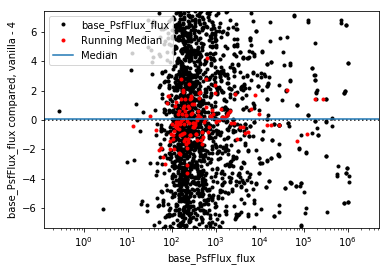

Number of Sources: 2751 Median: 0.0383619922487 Sigma MAD: 7.41876392849
All ccds in visit 903336


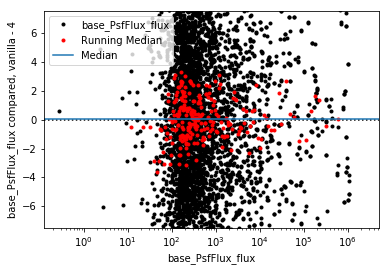

Number of Sources: 4988 Median: 0.025436604669 Sigma MAD: 7.53848881532
All sources brighter than 659.765581709


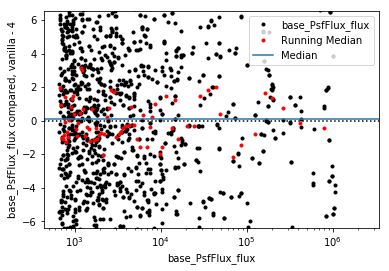

Number of Sources: 1495 Median: 0.0826722836721 Sigma MAD: 6.47567113493
903338
CCD: 25
Length of each catalogue: 3360 3496
With match: 3217
Difference in catalogue size: -136


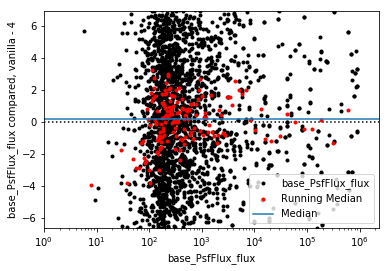

Number of Sources: 3217 Median: 0.171866814826 Sigma MAD: 6.81273924421
CCD: 18
Length of each catalogue: 2743 2876
With match: 2648
Difference in catalogue size: -133


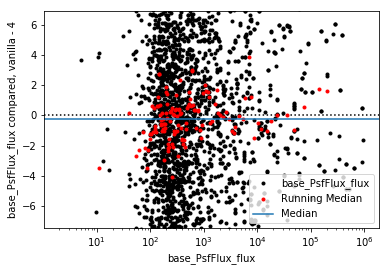

Number of Sources: 2648 Median: -0.264029667333 Sigma MAD: 7.22015073389
All ccds in visit 903338


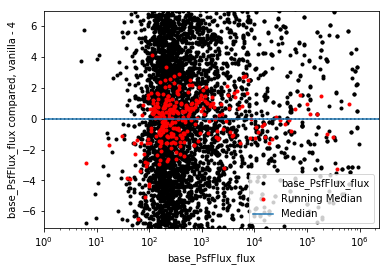

Number of Sources: 5865 Median: -0.0502932615216 Sigma MAD: 7.02956126667
All sources brighter than 649.463373752


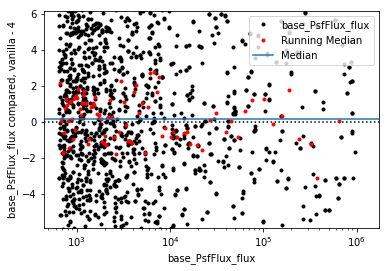

Number of Sources: 1758 Median: 0.132314085869 Sigma MAD: 6.0300818596
903342
CCD: 100
Length of each catalogue: 434 449
With match: 422
Difference in catalogue size: -15


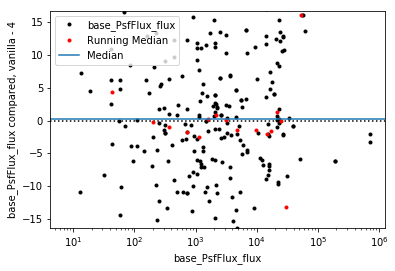

Number of Sources: 422 Median: 0.174835776452 Sigma MAD: 16.6256242488
CCD: 4
Length of each catalogue: 1683 1765
With match: 1605
Difference in catalogue size: -82


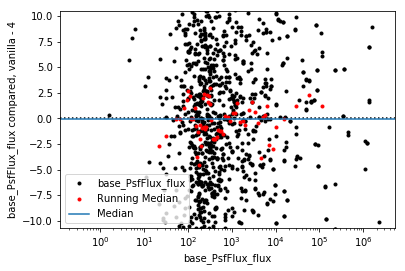

Number of Sources: 1605 Median: -0.0895167256572 Sigma MAD: 10.6057181231
CCD: 10
Length of each catalogue: 691 715
With match: 666
Difference in catalogue size: -24


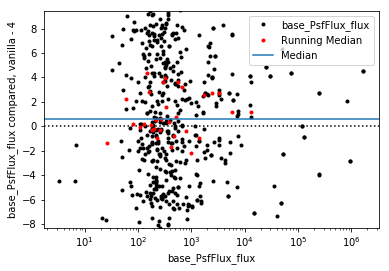

Number of Sources: 666 Median: 0.56607469563 Sigma MAD: 8.89943812239
All ccds in visit 903342


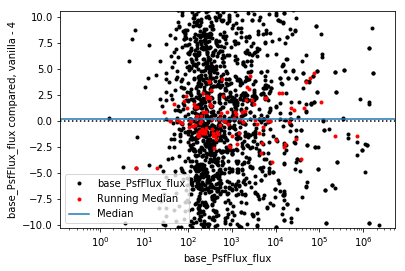

Number of Sources: 2693 Median: 0.135687089206 Sigma MAD: 10.4445922067
All sources brighter than 1426.55581613


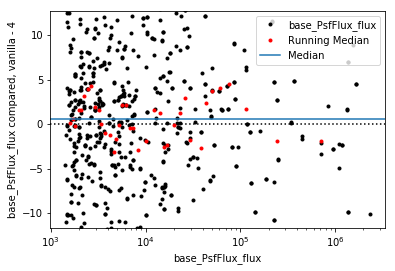

Number of Sources: 806 Median: 0.558269397414 Sigma MAD: 12.2154049188
903344
CCD: 0
Length of each catalogue: 1423 1493
With match: 1364
Difference in catalogue size: -70


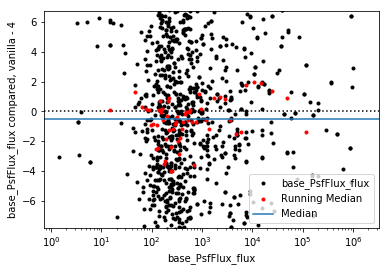

Number of Sources: 1364 Median: -0.529156491304 Sigma MAD: 7.28297414192
CCD: 5
Length of each catalogue: 2674 2805
With match: 2571
Difference in catalogue size: -131


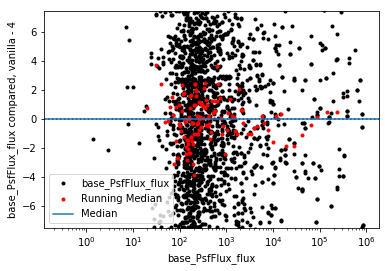

Number of Sources: 2571 Median: -0.0289270967481 Sigma MAD: 7.46094173416
CCD: 11
Length of each catalogue: 1219 1264
With match: 1175
Difference in catalogue size: -45


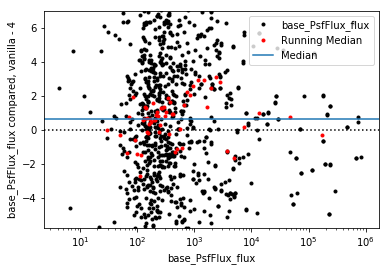

Number of Sources: 1175 Median: 0.622664908842 Sigma MAD: 6.3862516749
All ccds in visit 903344


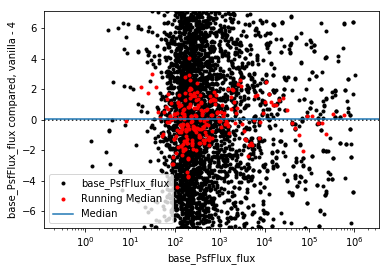

Number of Sources: 5110 Median: 0.0210000732294 Sigma MAD: 7.12970514597
All sources brighter than 586.371315338


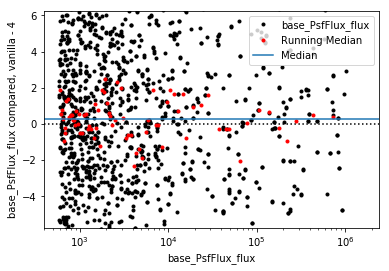

Number of Sources: 1531 Median: 0.260307214959 Sigma MAD: 6.00719473623
903346
CCD: 12
Length of each catalogue: 1385 1435
With match: 1338
Difference in catalogue size: -50


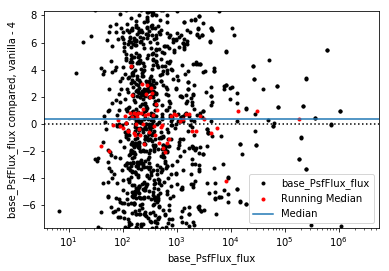

Number of Sources: 1338 Median: 0.333087529837 Sigma MAD: 8.01840820324
CCD: 1
Length of each catalogue: 1447 1519
With match: 1388
Difference in catalogue size: -72


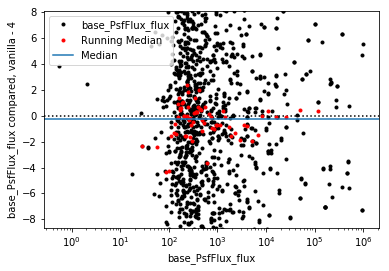

Number of Sources: 1388 Median: -0.280691727484 Sigma MAD: 8.39901731233
CCD: 6
Length of each catalogue: 2917 3061
With match: 2810
Difference in catalogue size: -144


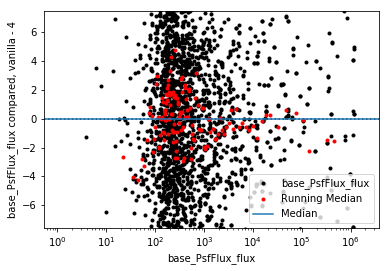

Number of Sources: 2810 Median: -0.0458771727084 Sigma MAD: 7.53672244272
All ccds in visit 903346


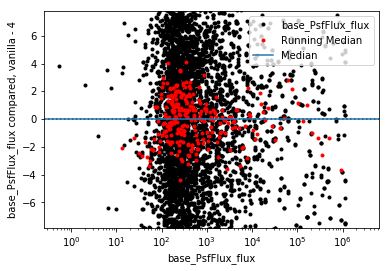

Number of Sources: 5536 Median: -0.0153663419065 Sigma MAD: 7.82773751574
All sources brighter than 713.898248571


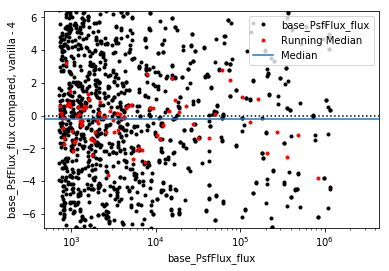

Number of Sources: 1654 Median: -0.221992482631 Sigma MAD: 6.63837733114
All sources in all visits


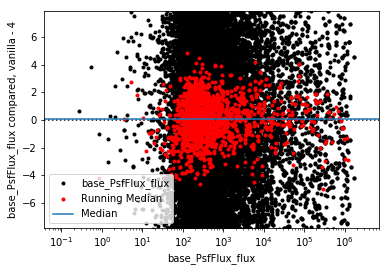

Number of Sources: 29772 Median: 0.0405017222797 Sigma MAD: 7.88602956721
All sources brighter than 705.845987176


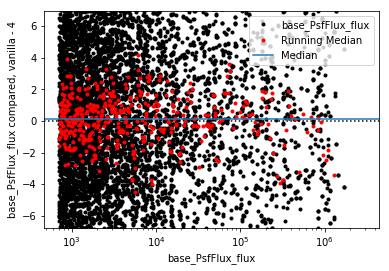

Number of Sources: 8915 Median: 0.105884007046 Sigma MAD: 6.88939278212


In [18]:
from astropy.table import Table, vstack

filt = "HSC-R"
visit = 903334
patch = "5,4"
tract = 0

if filt == "HSC-R":
    pointing = "00533/"
elif filt == "HSC-I":
    pointing = "00671/"


flux_col = "base_PsfFlux_flux"
g_type = "sub"
visits = [903334, 903336, 903338, 903342, 903344, 903346]

for flux_col in set(bad_cols):
    print(flux_col)
    i = 1
    for visit in visits:
        print(visit)
        t, t_comp, med, sig_mad = visit_analysis(visit, filt, patch, tract, g_type=g_type)
    
        if i == 1:
            t_all = t
            t_all_comp = t_comp
        else:
            t_all = vstack([t_all, t])
            t_all_comp = vstack([t_all_comp, t_comp])
        i += 1
        
    print("All sources in all visits")        
    med_all, sig_mad_all = flux_diff(t_all, t_all_comp, flux_col, g_type=g_type)
    med_all_bright, sig_mad_all_bright = bright_flux_diff(t_all, t_all_comp, flux_col, \
                                                      g_type=g_type)
